In [1]:
require("dplyr")
require("ggplot2")
require("ggpubr")
require("stringr")

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: ggpubr

Loading required package: stringr



In [2]:
fig3_basics = read.csv(file = "../../output/02_tables/04_source_data/fig3_NotContam_alllessandmorethan10_FreqCulGenera_long.csv", row.names = 1) %>% as.data.frame()

#just checking... 
fig3_basics %>% head(n=2)
colnames(fig3_basics)

,FID,nSIRS_class,nSIRS_score,Total.QC.reads,Species,Exact.abundance,Relative.abundance,Genus,Isolation.related.contaminant..p.0.25.,Library.prep.related.contaminant..p.0.25.,Contaminant,Exact_count_morethaninc_10,Exact_count_morethaninc_2,higher_than_H,higher_than_nS.,higher_than_S.,higher_than_H_nS.,higher_than_nS._S
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,F01,H,0,33446083,Salmonella enterica,0,0,Salmonella,False,False,False,False,False,0,0,0,0,0
1,F02,H,0,25885619,Salmonella enterica,0,0,Salmonella,False,False,False,False,False,0,0,0,0,0


[1] "FID"                                      
 [2] "nSIRS_class"                              
 [3] "nSIRS_score"                              
 [4] "Total.QC.reads"                           
 [5] "Species"                                  
 [6] "Exact.abundance"                          
 [7] "Relative.abundance"                       
 [8] "Genus"                                    
 [9] "Isolation.related.contaminant..p.0.25."   
[10] "Library.prep.related.contaminant..p.0.25."
[11] "Contaminant"                              
[12] "Exact_count_morethaninc_10"               
[13] "Exact_count_morethaninc_2"                
[14] "higher_than_H"                            
[15] "higher_than_nS."                          
[16] "higher_than_S."                           
[17] "higher_than_H_nS."                        
[18] "higher_than_nS._S"

In [3]:
## Removal of the contaminants
fig3_contaminantFree <- fig3_basics %>% 
    filter(Contaminant == "False") %>% 
    mutate(Contaminant = factor(Contaminant, level = unique(Contaminant))) %>% 
    #including shortening the species name
    mutate(Species_complete = Species) %>% 
    mutate(Species_p1 = paste0(substr(Species_complete, 1,1))) %>% 
    mutate(Species_p2 = str_replace(Species_complete, "^[^\\s]+\\s", "")) %>% 
    mutate(Species = paste0(Species_p1, ". ", Species_p2), collapse = "") 

#just checking... 
fig3_contaminantFree[,c("Species", "Species_complete")] %>% unique() %>% head()
fig3_contaminantFree$Contaminant %>% table()

,Species,Species_complete
,<chr>,<chr>
1,S. enterica,Salmonella enterica
33,S. bongori,Salmonella bongori
65,S. sp. SSDFZ54,Salmonella sp. SSDFZ54
97,S. sp. 2018103,Salmonella sp. 2018103
129,S. sp. TC67,Salmonella sp. TC67
161,S. sp. M9397,Salmonella sp. M9397


.
False 
37056 

In [4]:
## Preprocessing data for genus level assesment
fig3_contaminantFree_sumGenus <- fig3_contaminantFree %>% 
    group_by(FID, nSIRS_class, nSIRS_score, Genus) %>% 
    summarize(sum_rel_abundance = sum(Relative.abundance), 
              sum_count_abundance = sum(Exact.abundance),.groups = "keep") %>% 
    filter(sum_rel_abundance != 0) 

max_abundance_H <- fig3_contaminantFree_sumGenus %>%
        filter(nSIRS_class == "H") %>% 
        group_by(Genus) %>%
        summarize(max_H = max(sum_rel_abundance), .groups = "keep")
    
max_abundance_nSneg <- fig3_contaminantFree_sumGenus %>%
        filter(nSIRS_class == "nS-") %>% 
        group_by(Genus) %>%
        summarize(max_nSneg = max(sum_rel_abundance), .groups = "keep")

max_abundance_Spos <- fig3_contaminantFree_sumGenus %>%
        filter(nSIRS_class == "S+") %>% 
        group_by(Genus) %>%
        summarize(max_Spos = max(sum_rel_abundance), .groups = "keep")

fig3_contaminantFree_sumGenus_maxAbundance <- fig3_contaminantFree_sumGenus %>%
        left_join(max_abundance_H, by = c("Genus")) %>% 
        left_join(max_abundance_nSneg, by = c("Genus")) %>% 
        left_join(max_abundance_Spos, by = c("Genus"))

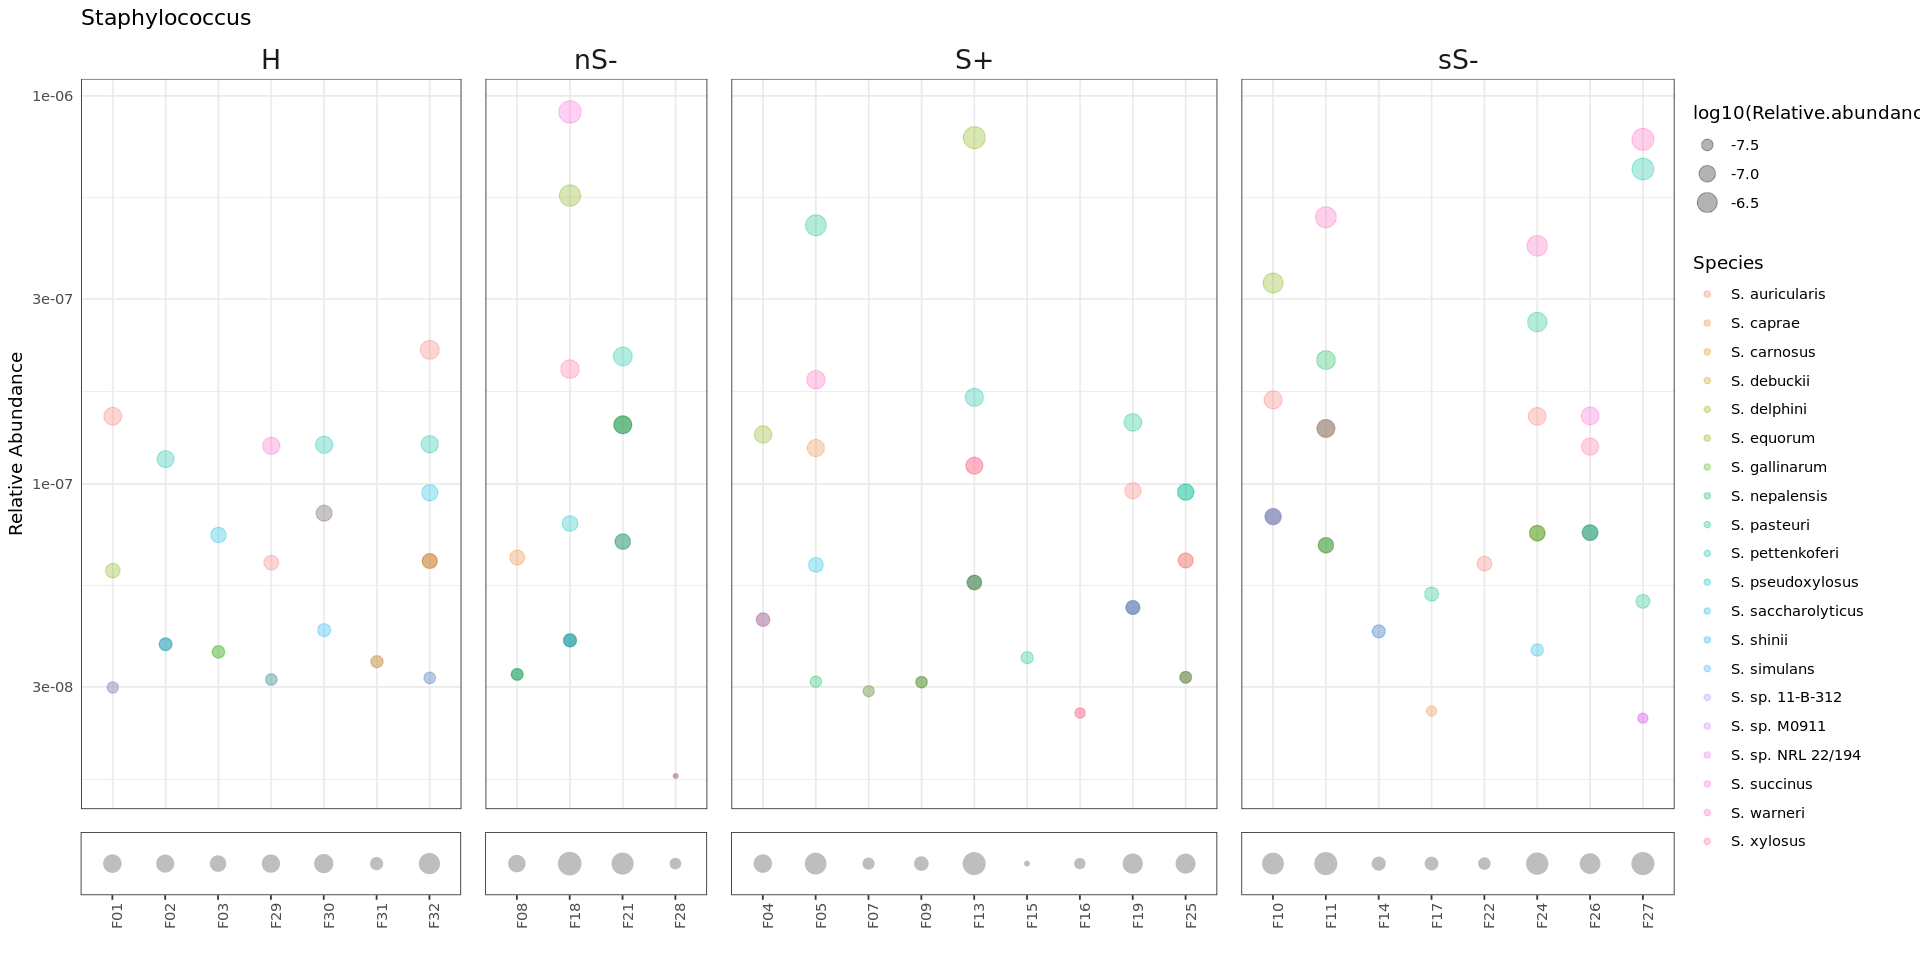

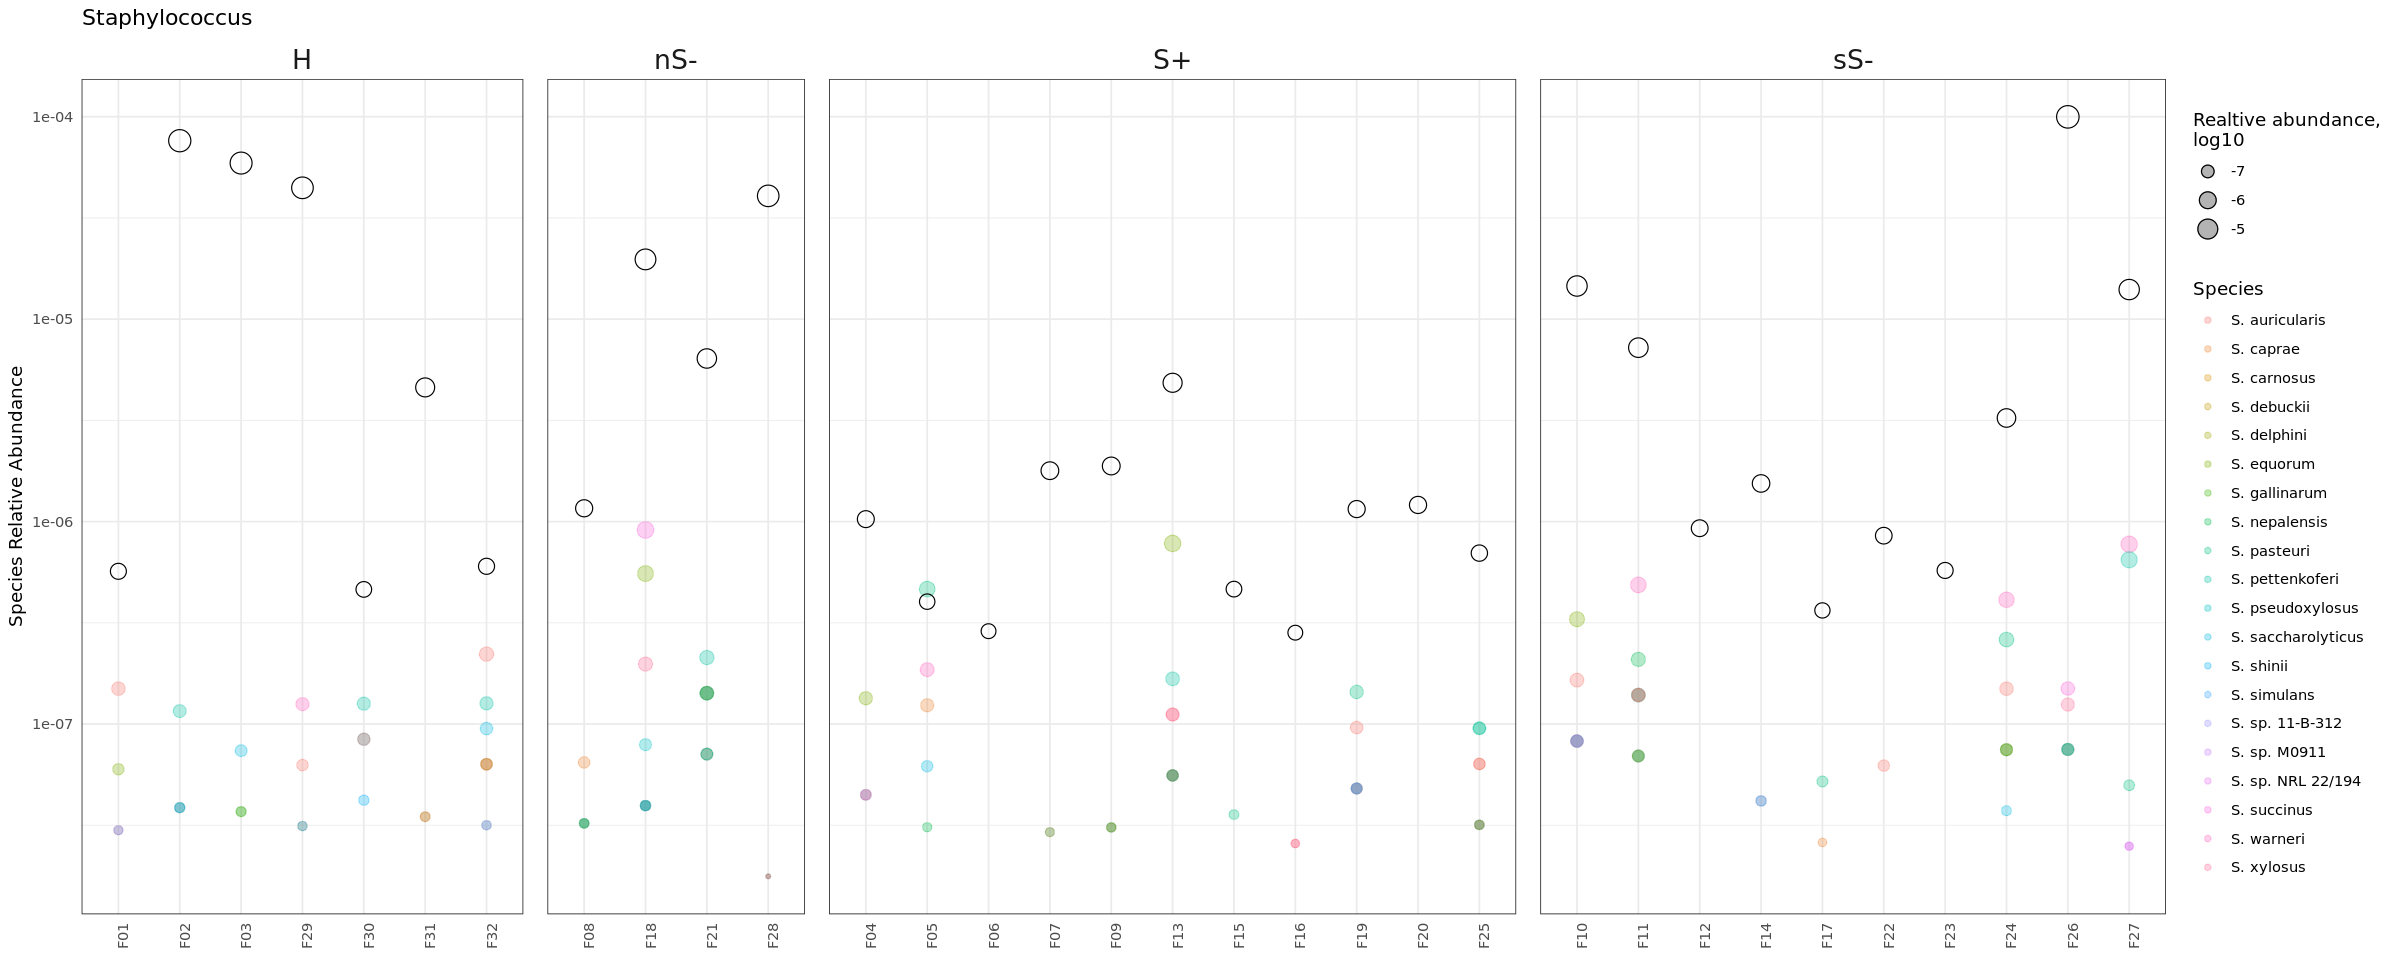

In [28]:
GOI="Staphylococcus"
fig3a.v1 <- fig3_contaminantFree %>%    
    filter(Genus == GOI) %>%
    filter(Relative.abundance != 0) %>% 
    ggplot(aes(x = FID, y = Relative.abundance)) + 
        geom_point(aes(col = Species, size = log10(Relative.abundance)), alpha = 0.3) + 
        facet_grid(cols = vars(nSIRS_class), scales = "free_x", space = "free_x", drop = TRUE) + 
        theme_bw() + 
        theme(axis.text.x = element_blank(), 
                strip.background = element_rect(color = "white", fill = "white"), 
                strip.text = element_text(size = 16), 
                panel.spacing = unit(1, "lines"), 
                axis.ticks = element_blank(),
                axis.title.x = element_blank(),
                ) + 
        scale_y_log10() + xlab("") + ylab("Relative Abundance") + ggtitle(GOI)

fig3a.v2 <- fig3_contaminantFree %>%    
    filter(Genus == GOI) %>%
    filter(Relative.abundance != 0) %>% 
    ggplot(aes(x = FID,)) + 
        geom_point(aes(y = Relative.abundance, col = Species, size = log10(Relative.abundance)), alpha = 0.3) + 
        geom_point(data = fig3_contaminantFree %>% 
                    filter(Genus == "Acinetobacter") %>% 
                    group_by(FID, nSIRS_class, nSIRS_score, Genus) %>% 
                    summarize(sum_rel_abundance = sum(Relative.abundance), .groups = "keep") %>% 
                    filter(sum_rel_abundance != 0), 
                   aes(y = sum_rel_abundance, size = log10(sum_rel_abundance), col = Genus), col = "black", 
                   alpha = 1, shape = 1, stroke = 0.5) + 
        facet_grid(cols = vars(nSIRS_class), scales = "free_x", space = "free_x", drop = TRUE) + 
        theme_bw() + 
        theme(axis.text.x = element_text(angle = 90, hjust = 1), 
                strip.background = element_rect(color = "white", fill = "white"), 
                strip.text.x = element_text(size = 16), 
                panel.spacing = unit(1, "lines"), 
                axis.ticks = element_blank(),
                axis.title.x = element_blank(),
                ) + 
        scale_y_log10() + ylab("Species Relative Abundance") + 
        labs(size = "Realtive abundance,\nlog10") + ggtitle(GOI)

options(repr.plot.width = 20, repr.plot.height = 1.2)
fig3b <- fig3_contaminantFree_sumGenus %>% 
    filter(Genus == GOI) %>% 
    ggplot(aes(x = FID, y = 10000)) + 
        geom_point(aes(size = log10(sum_rel_abundance)), alpha = 1, col = "grey") + 
        facet_grid(cols = vars(nSIRS_class), scales = "free_x", space = "free_x", drop = TRUE) + 
        theme_bw() + 
        theme(
            axis.text.y = element_text(color = NA),       
            axis.ticks.y = element_line(color = NA),          
            panel.grid.minor = element_blank(), 
            panel.grid.major = element_blank(),
            axis.text.x = element_text(angle = 90, hjust = 1), 
            strip.background = element_rect(color = "white", fill = "white"), 
            strip.text.x = element_blank(), 
            panel.spacing = unit(1, "lines"), 
            ) + 
    labs(size = "Realtive abundance,\nlog10") + scale_y_log10() + xlab("") + ylab("") 

options(repr.plot.width = 16, repr.plot.height = 8)
ggarrange(fig3a.v1, fig3b, heights = c(6,1),
    ncol = 1, nrow = 2, common.legend = TRUE, legend = "right") 

options(repr.plot.width = 20, repr.plot.height = 8)
fig3a.v2

Warning message:
“Removed 116 rows containing missing values or values outside the scale range (`geom_point()`).”


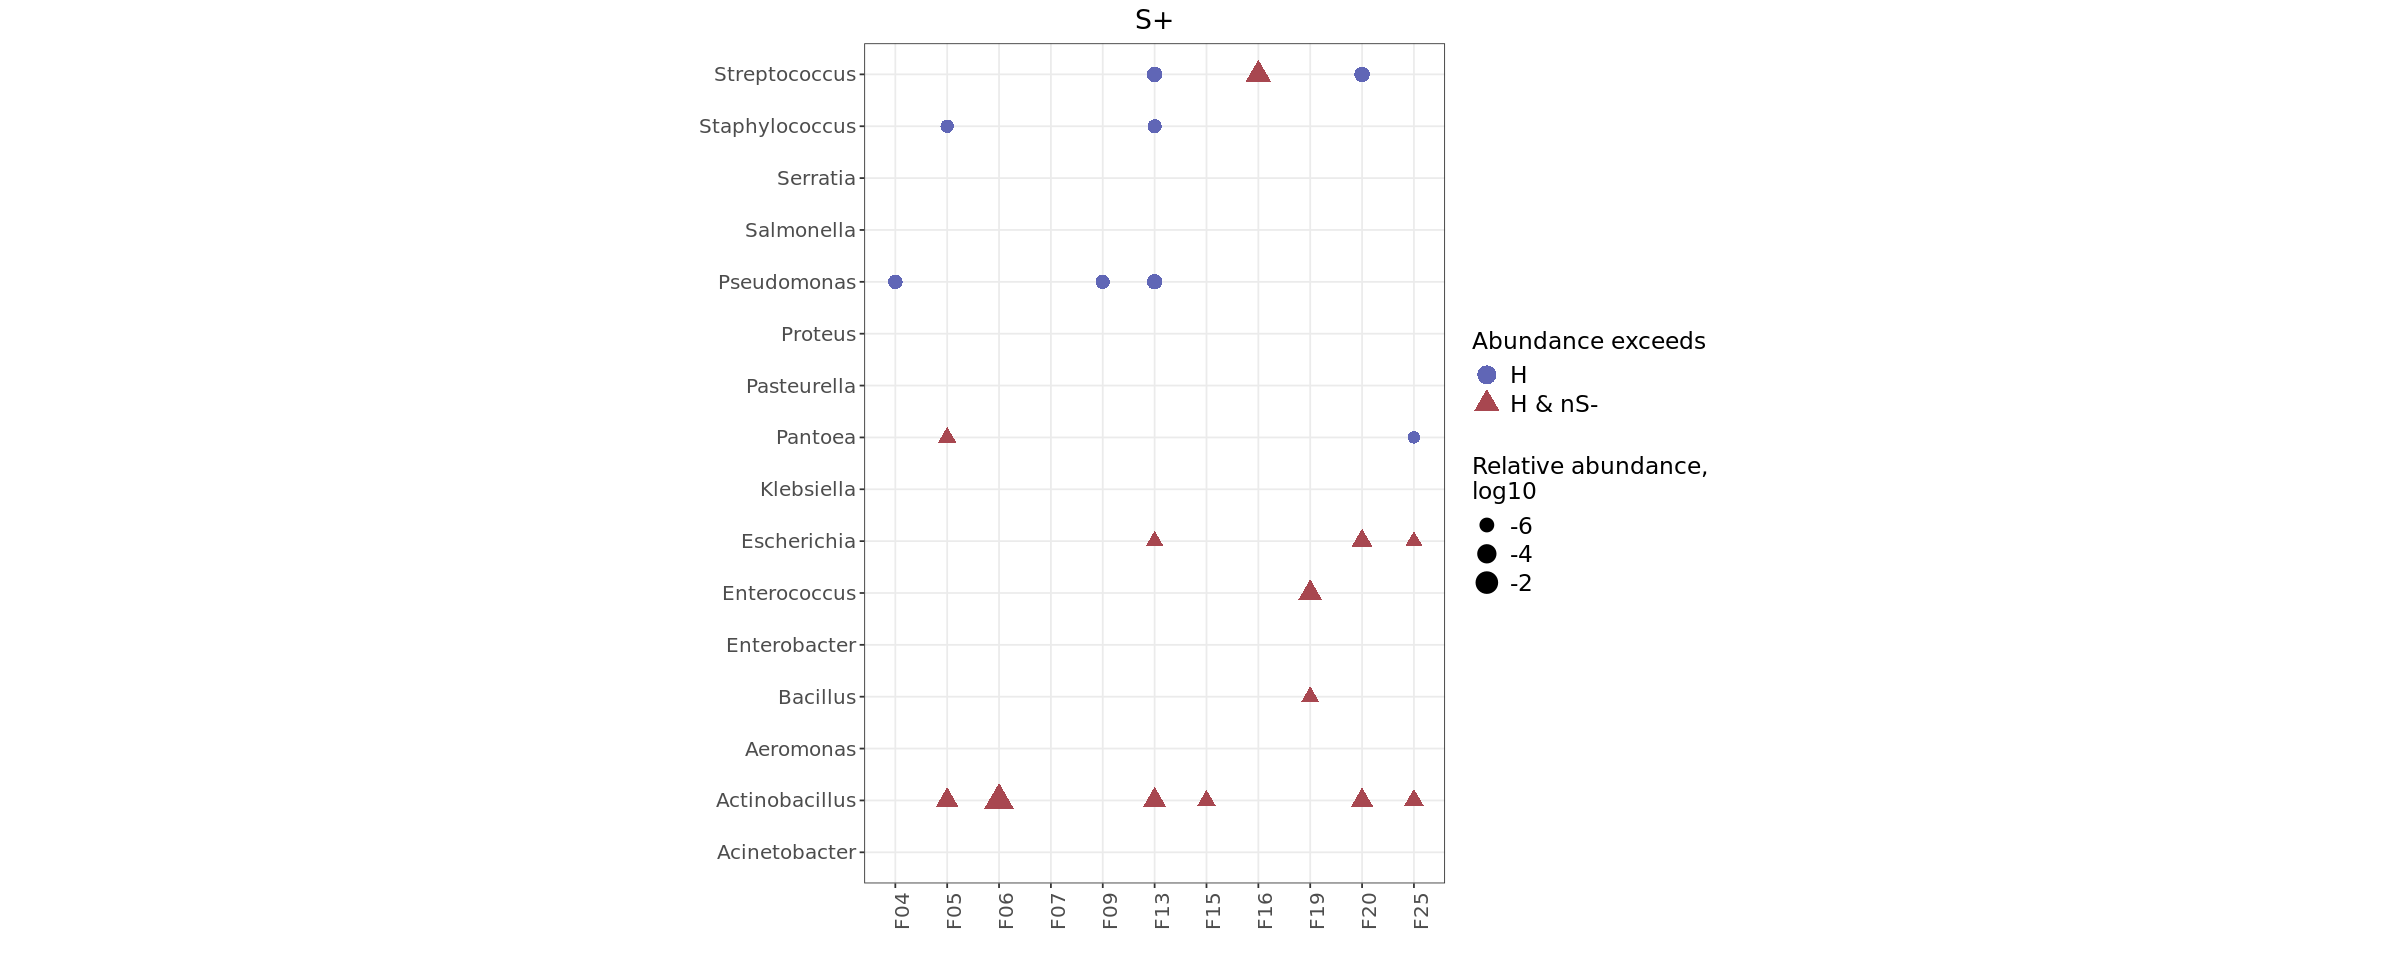

In [19]:
min_hard_count = 10
fig3_contaminantFree_sumGenus_maxAbundance %>% 
        mutate(tmp_col = ifelse(sum_rel_abundance > max_H & 
                                sum_rel_abundance < max_nSneg & 
                                sum_count_abundance > min_hard_count, yes = "H", no = 
                        ifelse(sum_rel_abundance < max_H & 
                               sum_rel_abundance > max_nSneg &
                               sum_count_abundance > min_hard_count, yes = "nS-", no =
                        ifelse(sum_rel_abundance > max_H & 
                               sum_rel_abundance > max_nSneg & 
                               sum_count_abundance > min_hard_count, yes = "H & nS-", no = "none")))) %>%
        mutate(tmp_col = factor(tmp_col, levels = c("H", "nS-", "H & nS-", "none"))) %>%
        filter(nSIRS_class == "S+") %>% 
        ggplot(aes(x = FID, y = Genus)) +
            geom_point(col = NA, aes(size = log10(sum_rel_abundance))) + coord_fixed() +
            geom_point(data = . %>% filter(sum_rel_abundance != 0) %>% filter(tmp_col != "none"), 
                       aes(x = FID, y = Genus, size = log10(sum_rel_abundance), col = tmp_col, shape = tmp_col)) + 
            theme_bw() + labs(col = "Abundance exceeds", shape = "Abundance exceeds", size = "Relative abundance,\nlog10", 
                            x = "", y = "") + 
            scale_color_manual(values = c("H" = "#6066B6", "H & nS-" = "#A84750", "nS-" = "#C7D0D6", "none" = "black")) +
            scale_shape_manual(values = c("H" = 16, "H & nS-" = 17, "nS-" = 15, "none" = 3)) +
            theme(axis.text.x = element_text(angle = 90, hjust = 1), 
                strip.background = element_rect(color = "white", fill = "white"), 
                axis.text = element_text(size = 12), # Increase text size in the facet labels
                panel.spacing = unit(1, "lines"), 
                legend.text = element_text(size = 14),   # Adjust legend text size
                legend.title = element_text(size = 14), 
                plot.title = element_text(hjust = 0.5, size = 16)
                ) + 
            guides(col = guide_legend(override.aes = list(size = 5))) + 
            ggtitle("S+")

Warning message:
“Removed 341 rows containing missing values or values outside the scale range (`geom_point()`).”


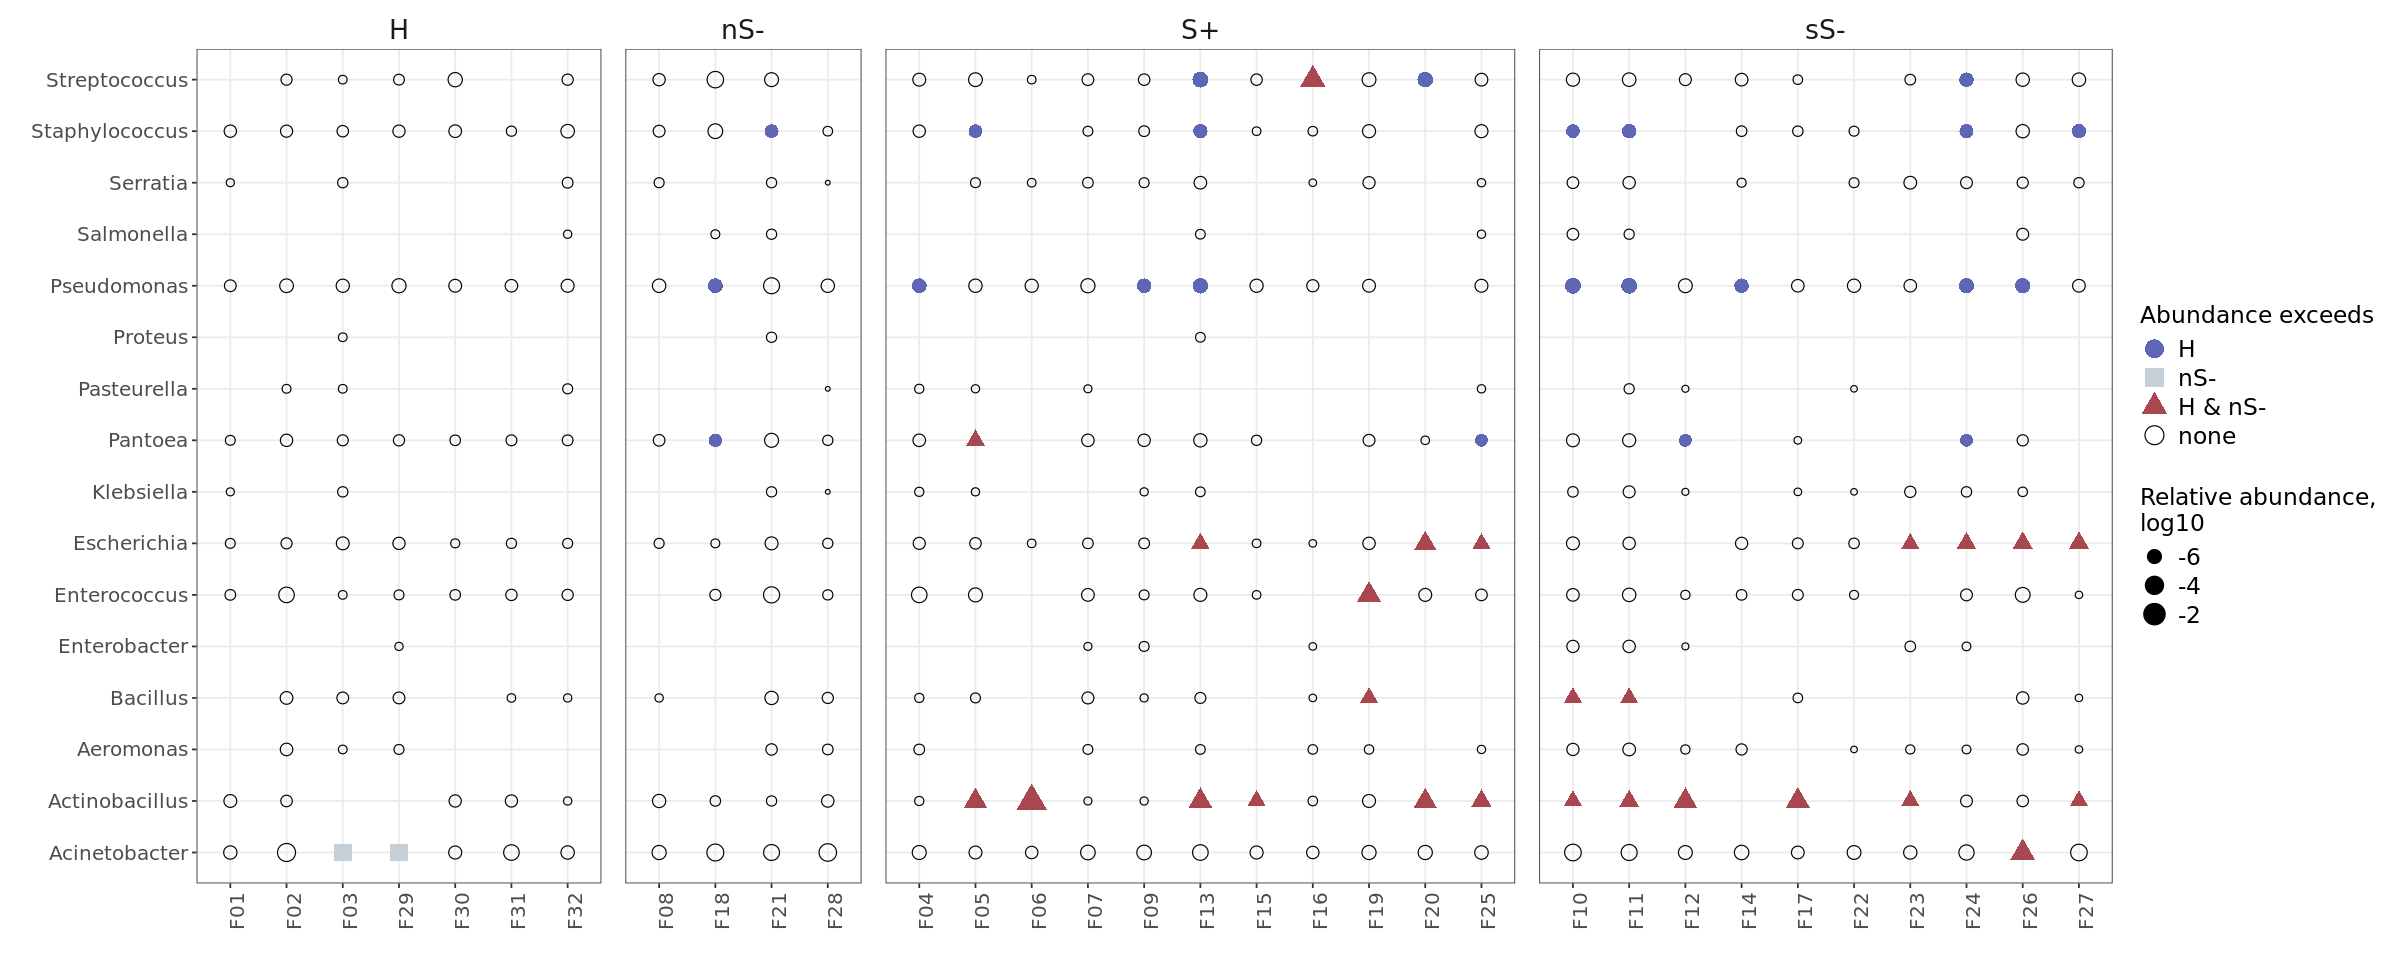

In [20]:
fig3_contaminantFree_sumGenus_maxAbundance %>% 
        mutate(tmp_col = ifelse(sum_rel_abundance > max_H & 
                                sum_rel_abundance < max_nSneg & 
                                sum_count_abundance > min_hard_count, yes = "H", no = 
                        ifelse(sum_rel_abundance < max_H & 
                               sum_rel_abundance > max_nSneg &
                               sum_count_abundance > min_hard_count, yes = "nS-", no =
                        ifelse(sum_rel_abundance > max_H & 
                               sum_rel_abundance > max_nSneg & 
                               sum_count_abundance > min_hard_count, yes = "H & nS-", no = "none")))) %>%
        mutate(tmp_col = factor(tmp_col, levels = c("H", "nS-", "H & nS-", "none"))) %>%
        ggplot(aes(x = FID, y = Genus)) +
            geom_point(col = NA, aes(size = log10(sum_rel_abundance))) + 
            geom_point(data = . %>% filter(sum_rel_abundance != 0), 
                       aes(x = FID, y = Genus, size = log10(sum_rel_abundance), col = tmp_col, shape = tmp_col)) + 
            theme_bw() + labs(col = "Abundance exceeds", shape = "Abundance exceeds", size = "Relative abundance,\nlog10", 
                            x = "", y = "") + 
            scale_color_manual(values = c("H" = "#6066B6", "H & nS-" = "#A84750", "nS-" = "#C7D0D6", "none" = "black")) +
            scale_shape_manual(values = c("H" = 16, "H & nS-" = 17, "nS-" = 15, "none" = 1)) +
            theme(axis.text.x = element_text(angle = 90, hjust = 1), 
                strip.background = element_rect(color = "white", fill = "white"), 
                axis.text = element_text(size = 12), # Increase text size in the facet labels
                panel.spacing = unit(1, "lines"), 
                legend.text = element_text(size = 14),   # Adjust legend text size
                legend.title = element_text(size = 14), 
                strip.text = element_text(size = 16),
                ) + 
            facet_grid(cols = vars(nSIRS_class), scales = "free_x", space = "free_x", drop = TRUE) + 
            guides(col = guide_legend(override.aes = list(size = 5))) 

Warning message:
“Removed 341 rows containing missing values or values outside the scale range (`geom_point()`).”


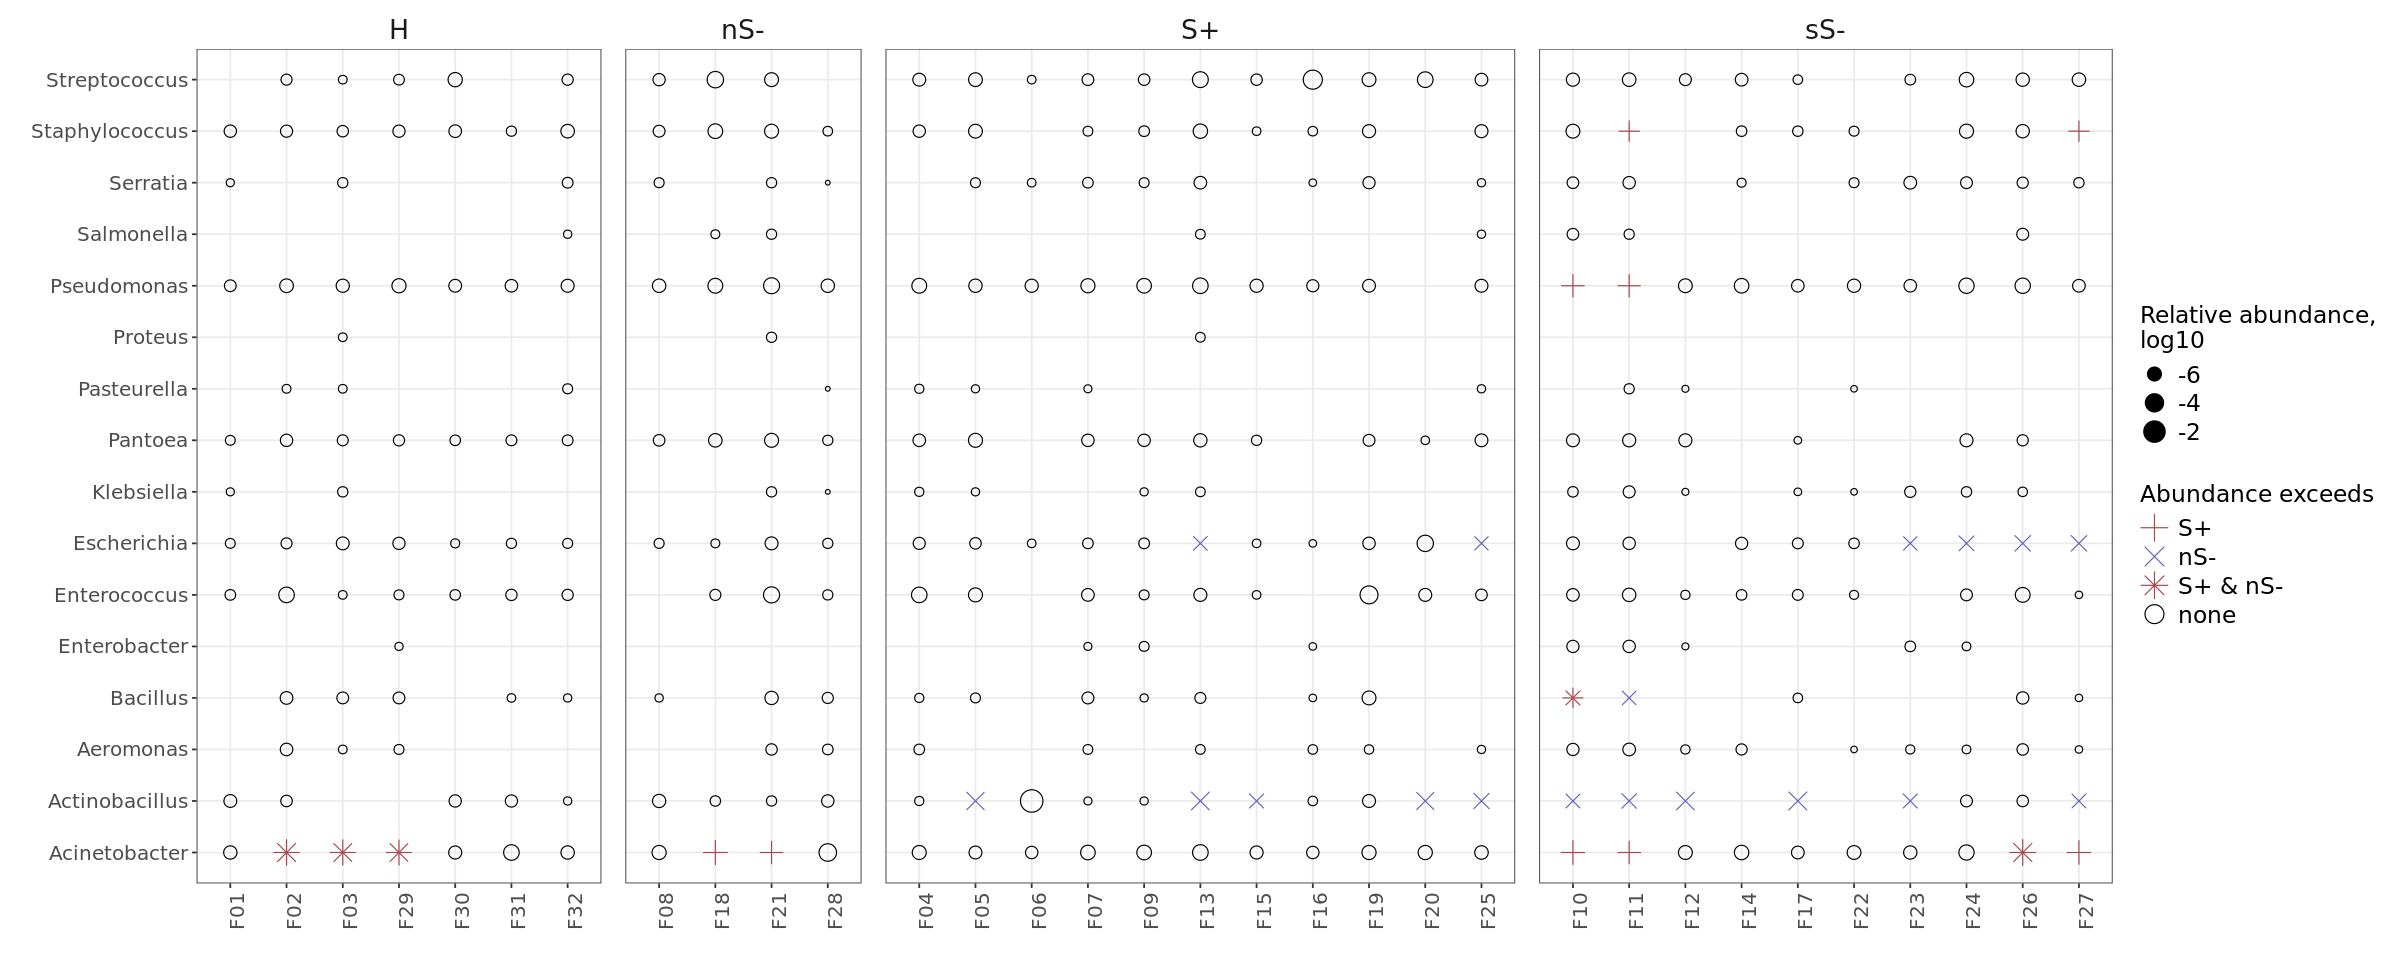

In [21]:
fig3_contaminantFree_sumGenus_maxAbundance %>% 
        mutate(tmp_col = ifelse(sum_rel_abundance > max_Spos & 
                                sum_rel_abundance < max_nSneg & 
                                sum_count_abundance > min_hard_count, yes = "S+", no = 
                        ifelse(sum_rel_abundance < max_Spos & 
                               sum_rel_abundance > max_nSneg &
                               sum_count_abundance > min_hard_count, yes = "nS-", no =
                        ifelse(sum_rel_abundance > max_Spos & 
                               sum_rel_abundance > max_nSneg & 
                               sum_count_abundance > min_hard_count, yes = "S+ & nS-", no = "none")))) %>%
        mutate(tmp_col = factor(tmp_col, levels = c("S+", "nS-", "S+ & nS-", "none"))) %>%
        ggplot(aes(x = FID, y = Genus)) +
            geom_point(col = NA) + 
            geom_point(data = . %>% filter(sum_rel_abundance != 0), 
                       aes(x = FID, y = Genus, size = log10(sum_rel_abundance), col = tmp_col, shape = tmp_col)) + 
            theme_bw() + labs(col = "Abundance exceeds", shape = "Abundance exceeds", size = "Relative abundance,\nlog10", 
                            x = "", y = "") + 
            scale_color_manual(values = c("S+" = "#A84750", "S+ & nS-" = "#A84750", "nS-" = "#6066B6", "none" = "black")) +
            scale_shape_manual(values = c("S+" = 3, "S+ & nS-" = 8, "nS-" = 4, "none" = 1)) +
            theme(axis.text.x = element_text(angle = 90, hjust = 1), 
                strip.background = element_rect(color = "white", fill = "white"), 
                axis.text = element_text(size = 12), # Increase text size in the facet labels
                panel.spacing = unit(1, "lines"), 
                legend.text = element_text(size = 14),   # Adjust legend text size
                legend.title = element_text(size = 14), 
                strip.text = element_text(size = 16),
                ) + 
            facet_grid(cols = vars(nSIRS_class), scales = "free_x", space = "free_x", drop = TRUE) + 
            guides(col = guide_legend(override.aes = list(size = 5))) 